### Goal: Join all of the diseased single nucleus RNA-seq LV ventricle datasets

The goal of this script is to join all of the external datasets and internal (Drop-seq) snRNA-seq datasets together. 

In each of their individual directories, we examined the processed data of each publication using a simple scanpy preprocessing procedure with Harmony integration. As the batch effects are quite significant between different datasets, we will use scVI integration eventually to harmonize the UMAP embedding.

In addition to the in house Penn dataset, we will include the diseased donors from the following datasets: 

1. Koenig et al. 2022 - DCM
2. Chaffin et al. 2022 - DCM, HCM
3. Reichart et al. 2022 - DCM
4. Simonson et al. 2023 - ICM
5. Kuppe et al. 2022 - AMI, ICM
6. Hill et al. 2022 - pediatric HF

### Consistent metadata across studies

We will keep the follow metadata (per cell) from each of the datasets

1. Donor id
2. Donor age
3. Donor sex
4. Disease
5. Technology used for library generation 
6. Cell or nuclei (should all be nuclei only)
7. Region (e.g. chamber such as LV)
8. Study
9. cell_type annotation (original annotation from each study, or our annotations for Penn and ENCODE v4 dataset)
10. consistent_cell_type (annotation from each study, but made consistent across all studies)

#### Import libraries

In [1]:
import scanpy as sc
import anndata as adata
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import anndata as ad
from collections import Counter
import seaborn as sns
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import re
import gc
from adjustText import adjust_text
from sklearn.mixture import GaussianMixture

In [2]:
metadata_to_keep = ["age", 
                    "donor_id", 
                    "sex", 
                    "region", 
                    "cell_type",
                    "disease",
                    "consistent_cell_type",
                    "study", 
                    "technology", 
                    "cell_or_nuclei"]

### Sequentially load each of the datasets 
1. Confirm that the counts are the RAW counts (not normalized)

In [3]:
def confirm_raw_counts(adata):
    """
    Check if every value in adata.X.sum(axis=1), the sum of counts across all genes per cell, is an integer.   

    Parameters:
    adata (AnnData): The AnnData object containing the data matrix (adata.X).

    Returns:
    bool: True if all sums are integers, False otherwise.
    """
    # Sum across rows (axis=1), which correspond to the genes
    sums = adata.X.sum(axis=1)
    
    # Check if all sums are integers by comparing them to their rounded versions
    return np.all(np.equal(sums, np.round(sums)))

### Penn

In [4]:
%%time
Penn_adata = sc.read_h5ad("../internal_datasets/postnatal_datasets/combined_analysis/processed_Penn_diseased.h5ad")
Penn_adata.X = Penn_adata.layers['counts']
print("All raw counts?: " + str (confirm_raw_counts(Penn_adata)) )
Penn_adata.obs = Penn_adata.obs[metadata_to_keep]

All raw counts?: True
CPU times: user 325 ms, sys: 319 ms, total: 643 ms
Wall time: 1.21 s


In [5]:
Penn_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei
index,,,,,,,,,,
K1617-LV-FACS:AAAAACCACGAT,64,K1617,male,LV,Endothelial,DCM,Endothelial,Penn,Dropseq,Nuclei
K1617-LV-FACS:AAAAATGTTCAA,64,K1617,male,LV,Endothelial,DCM,Endothelial,Penn,Dropseq,Nuclei
K1617-LV-FACS:AAAACAGCCCAC,64,K1617,male,LV,Cardiomyocyte,DCM,Cardiomyocyte,Penn,Dropseq,Nuclei
K1617-LV-FACS:AAAACCTCCATT,64,K1617,male,LV,Pericyte,DCM,Pericyte,Penn,Dropseq,Nuclei
K1617-LV-FACS:AAAAGCAGGTTG,64,K1617,male,LV,Fibroblast,DCM,Fibroblast,Penn,Dropseq,Nuclei


In [6]:
# create a sample_id column, as donor_ids can have multiple sample_ids
Penn_adata.obs['sample_id'] = Penn_adata.obs_names.str.split(":").str[0]
Penn_adata.obs['barcode'] = Penn_adata.obs_names.str.split(":").str[1]

In [7]:
Penn_adata.obs_names = Penn_adata.obs['sample_id'].astype(str) + ":" + Penn_adata.obs['barcode'].astype(str)

In [8]:
Counter(Penn_adata.obs_names).most_common(1)[0]

('K1617-LV-FACS:AAAAACCACGAT', 1)

In [9]:
Penn_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei,sample_id,barcode
K1617-LV-FACS:AAAAACCACGAT,64,K1617,male,LV,Endothelial,DCM,Endothelial,Penn,Dropseq,Nuclei,K1617-LV-FACS,AAAAACCACGAT
K1617-LV-FACS:AAAAATGTTCAA,64,K1617,male,LV,Endothelial,DCM,Endothelial,Penn,Dropseq,Nuclei,K1617-LV-FACS,AAAAATGTTCAA
K1617-LV-FACS:AAAACAGCCCAC,64,K1617,male,LV,Cardiomyocyte,DCM,Cardiomyocyte,Penn,Dropseq,Nuclei,K1617-LV-FACS,AAAACAGCCCAC
K1617-LV-FACS:AAAACCTCCATT,64,K1617,male,LV,Pericyte,DCM,Pericyte,Penn,Dropseq,Nuclei,K1617-LV-FACS,AAAACCTCCATT
K1617-LV-FACS:AAAAGCAGGTTG,64,K1617,male,LV,Fibroblast,DCM,Fibroblast,Penn,Dropseq,Nuclei,K1617-LV-FACS,AAAAGCAGGTTG


#### Chaffin et al. 2022 

In [10]:
%%time
Chaffin_adata = sc.read_h5ad("../external_datasets/Chaffin_et_al_2022/processed_Chaffin_diseased.h5ad")
Chaffin_adata.X = Chaffin_adata.layers['counts']
print("All raw counts?: " + str (confirm_raw_counts(Chaffin_adata)) )
Chaffin_adata.obs = Chaffin_adata.obs[metadata_to_keep]

All raw counts?: True
CPU times: user 2.01 s, sys: 12.4 s, total: 14.4 s
Wall time: 18 s


In [11]:
Chaffin_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei
ACAGCCGCAAGCGAGT-1-1,54.0,P1422,male,LV,Cardiomyocyte_I,HCM,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei
ATATCCTGTCCCTAAA-1-1,54.0,P1422,male,LV,Cardiomyocyte_I,HCM,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei
CAATGACCAGTTGTCA-1-1,54.0,P1422,male,LV,Cardiomyocyte_I,HCM,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei
CTAGACACAAGGTTGG-1-1,54.0,P1422,male,LV,Cardiomyocyte_I,HCM,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei
ATCGTCCGTATTTCTC-1-1,54.0,P1422,male,LV,Cardiomyocyte_I,HCM,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei


In [12]:
Chaffin_adata.obs['barcode'] = Chaffin_adata.obs_names

In [13]:
Chaffin_adata.obs_names = Chaffin_adata.obs['donor_id'].astype(str) + ":" + Chaffin_adata.obs['barcode'].astype(str)

In [14]:
Counter(Chaffin_adata.obs_names).most_common(1)[0]

Chaffin_adata.obs['sample_id'] = Chaffin_adata.obs['donor_id']

In [15]:
Chaffin_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei,barcode,sample_id
P1422:ACAGCCGCAAGCGAGT-1-1,54.0,P1422,male,LV,Cardiomyocyte_I,HCM,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei,ACAGCCGCAAGCGAGT-1-1,P1422
P1422:ATATCCTGTCCCTAAA-1-1,54.0,P1422,male,LV,Cardiomyocyte_I,HCM,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei,ATATCCTGTCCCTAAA-1-1,P1422
P1422:CAATGACCAGTTGTCA-1-1,54.0,P1422,male,LV,Cardiomyocyte_I,HCM,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei,CAATGACCAGTTGTCA-1-1,P1422
P1422:CTAGACACAAGGTTGG-1-1,54.0,P1422,male,LV,Cardiomyocyte_I,HCM,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei,CTAGACACAAGGTTGG-1-1,P1422
P1422:ATCGTCCGTATTTCTC-1-1,54.0,P1422,male,LV,Cardiomyocyte_I,HCM,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei,ATCGTCCGTATTTCTC-1-1,P1422


#### Simonson et al. 2023

In [16]:
%%time
# read in the entire dataset
Simonson_adata = sc.read_h5ad("../external_datasets/Simonson_et_al_2023/processed_Simonson_diseased.h5ad")
Simonson_adata.X = Simonson_adata.layers['counts']
print("All raw counts?: " + str (confirm_raw_counts(Simonson_adata)) )
Simonson_adata.obs = Simonson_adata.obs[metadata_to_keep]

All raw counts?: True
CPU times: user 352 ms, sys: 1 s, total: 1.35 s
Wall time: 3.21 s


In [17]:
Simonson_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei
TCCCACACAATAGTGA-1-0,55,P1364,female,LV,Cardiomyocyte I,ICM,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei
AATGCCACAACTTCTT-1-0,55,P1364,female,LV,Cardiomyocyte I,ICM,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei
ATTACTCCAATAGTAG-1-0,55,P1364,female,LV,Cardiomyocyte I,ICM,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei
ATCGTGACACCTGTCT-1-0,55,P1364,female,LV,Cardiomyocyte I,ICM,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei
CAGTTAGCAACCGCTG-1-0,55,P1364,female,LV,Cardiomyocyte I,ICM,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei


In [18]:
Simonson_adata.obs['barcode'] = Simonson_adata.obs_names

In [19]:
Simonson_adata.obs_names = Simonson_adata.obs['donor_id'].astype(str) + ":" + Simonson_adata.obs['barcode'].astype(str)

In [20]:
Counter(Simonson_adata.obs_names).most_common(1)[0]
Simonson_adata.obs['sample_id'] = Simonson_adata.obs['donor_id']

In [21]:
Simonson_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei,barcode,sample_id
P1364:TCCCACACAATAGTGA-1-0,55,P1364,female,LV,Cardiomyocyte I,ICM,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei,TCCCACACAATAGTGA-1-0,P1364
P1364:AATGCCACAACTTCTT-1-0,55,P1364,female,LV,Cardiomyocyte I,ICM,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei,AATGCCACAACTTCTT-1-0,P1364
P1364:ATTACTCCAATAGTAG-1-0,55,P1364,female,LV,Cardiomyocyte I,ICM,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei,ATTACTCCAATAGTAG-1-0,P1364
P1364:ATCGTGACACCTGTCT-1-0,55,P1364,female,LV,Cardiomyocyte I,ICM,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei,ATCGTGACACCTGTCT-1-0,P1364
P1364:CAGTTAGCAACCGCTG-1-0,55,P1364,female,LV,Cardiomyocyte I,ICM,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei,CAGTTAGCAACCGCTG-1-0,P1364


#### Koenig et al. 2022 

In [22]:
%%time
Koenig_adata = sc.read_h5ad("../external_datasets/Koenig_et_al_2022/processed_Koenig_diseased.h5ad")
Koenig_adata.X = Koenig_adata.layers['counts']
print("All raw counts?: " + str (confirm_raw_counts(Koenig_adata)) )
Koenig_adata.obs = Koenig_adata.obs[metadata_to_keep]

All raw counts?: True
CPU times: user 518 ms, sys: 2.16 s, total: 2.67 s
Wall time: 3.6 s


In [23]:
Koenig_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei
index,,,,,,,,,,
H_ZC-LVAD_CCTTCGATCCTAAGTG,58,H_ZC-LVAD,male,LV,Endocardium,DCM,Endocardial,Koenig 2022,5prime-v1,Nuclei
H_ZC-LVAD_CGATCGGAGTTGAGAT,58,H_ZC-LVAD,male,LV,Endocardium,DCM,Endocardial,Koenig 2022,5prime-v1,Nuclei
H_ZC-LVAD_AACTCAGGTCTGGAGA,58,H_ZC-LVAD,male,LV,Endocardium,DCM,Endocardial,Koenig 2022,5prime-v1,Nuclei
H_ZC-LVAD_CATCAGACACACGCTG,58,H_ZC-LVAD,male,LV,Endocardium,DCM,Endocardial,Koenig 2022,5prime-v1,Nuclei
H_ZC-LVAD_CTGAAACCAGTGAGTG,58,H_ZC-LVAD,male,LV,Endocardium,DCM,Endocardial,Koenig 2022,5prime-v1,Nuclei


In [24]:
Koenig_adata.obs['barcode'] = Koenig_adata.obs_names.str.split("_").str[-1]

In [25]:
Koenig_adata.obs_names = Koenig_adata.obs['donor_id'].astype(str) + ":" + Koenig_adata.obs['barcode'].astype(str)

In [26]:
Counter(Koenig_adata.obs_names).most_common(1)[0]
Koenig_adata.obs['sample_id'] = Koenig_adata.obs['donor_id']

In [27]:
Koenig_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei,barcode,sample_id
H_ZC-LVAD:CCTTCGATCCTAAGTG,58,H_ZC-LVAD,male,LV,Endocardium,DCM,Endocardial,Koenig 2022,5prime-v1,Nuclei,CCTTCGATCCTAAGTG,H_ZC-LVAD
H_ZC-LVAD:CGATCGGAGTTGAGAT,58,H_ZC-LVAD,male,LV,Endocardium,DCM,Endocardial,Koenig 2022,5prime-v1,Nuclei,CGATCGGAGTTGAGAT,H_ZC-LVAD
H_ZC-LVAD:AACTCAGGTCTGGAGA,58,H_ZC-LVAD,male,LV,Endocardium,DCM,Endocardial,Koenig 2022,5prime-v1,Nuclei,AACTCAGGTCTGGAGA,H_ZC-LVAD
H_ZC-LVAD:CATCAGACACACGCTG,58,H_ZC-LVAD,male,LV,Endocardium,DCM,Endocardial,Koenig 2022,5prime-v1,Nuclei,CATCAGACACACGCTG,H_ZC-LVAD
H_ZC-LVAD:CTGAAACCAGTGAGTG,58,H_ZC-LVAD,male,LV,Endocardium,DCM,Endocardial,Koenig 2022,5prime-v1,Nuclei,CTGAAACCAGTGAGTG,H_ZC-LVAD


#### Kuppe et al. 2022

In [28]:
Kuppe_adata = sc.read_h5ad("../external_datasets/Kuppe_et_al_2022/02_processed_Kuppe_D.h5ad")
#Kuppe_adata.obs['disease'] = "MI"
Kuppe_adata.X = Kuppe_adata.layers['counts']
print("All raw counts?: " + str (confirm_raw_counts(Kuppe_adata)) )
Kuppe_adata.obs = Kuppe_adata.obs[metadata_to_keep]

All raw counts?: True


In [29]:
Kuppe_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei
index,,,,,,,,,,
AAACCCAAGGAACGAA-1_1_1_1_1_1_1_1_1_1_1_1_1_1,57,P3,male,LV,Cardiomyocyte,AMI,Cardiomyocyte,Kuppe 2022,3prime-v3,Nuclei
AAACCCACAAGGGTCA-1_1_1_1_1_1_1_1_1_1_1_1_1_1,57,P3,male,LV,Fibroblast,AMI,Fibroblast,Kuppe 2022,3prime-v3,Nuclei
AAACCCACAGCTACTA-1_1_1_1_1_1_1_1_1_1_1_1_1_1,57,P3,male,LV,Cardiomyocyte,AMI,Cardiomyocyte,Kuppe 2022,3prime-v3,Nuclei
AAACCCACATGGAATA-1_1_1_1_1_1_1_1_1_1_1_1_1_1,57,P3,male,LV,Cycling cells,AMI,Myeloid,Kuppe 2022,3prime-v3,Nuclei
AAACCCAGTGCGACAA-1_1_1_1_1_1_1_1_1_1_1_1_1_1,57,P3,male,LV,Cardiomyocyte,AMI,Cardiomyocyte,Kuppe 2022,3prime-v3,Nuclei


In [30]:
#Kuppe_adata.obs_names = Kuppe_adata.obs_names.str.split("-").str[0]

In [31]:
Kuppe_adata.obs_names = Kuppe_adata.obs.donor_id.astype(str) + ":" + Kuppe_adata.obs_names.astype(str)

In [32]:
Kuppe_adata.obs['barcode'] = Kuppe_adata.obs_names.str.split(":").str[-1]

In [33]:
print(Counter(Kuppe_adata.obs_names).most_common(1)[0])
Kuppe_adata.obs['sample_id'] = Kuppe_adata.obs['donor_id']

('P3:AAACCCAAGGAACGAA-1_1_1_1_1_1_1_1_1_1_1_1_1_1', 1)


In [34]:
Kuppe_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei,barcode,sample_id
P3:AAACCCAAGGAACGAA-1_1_1_1_1_1_1_1_1_1_1_1_1_1,57,P3,male,LV,Cardiomyocyte,AMI,Cardiomyocyte,Kuppe 2022,3prime-v3,Nuclei,AAACCCAAGGAACGAA-1_1_1_1_1_1_1_1_1_1_1_1_1_1,P3
P3:AAACCCACAAGGGTCA-1_1_1_1_1_1_1_1_1_1_1_1_1_1,57,P3,male,LV,Fibroblast,AMI,Fibroblast,Kuppe 2022,3prime-v3,Nuclei,AAACCCACAAGGGTCA-1_1_1_1_1_1_1_1_1_1_1_1_1_1,P3
P3:AAACCCACAGCTACTA-1_1_1_1_1_1_1_1_1_1_1_1_1_1,57,P3,male,LV,Cardiomyocyte,AMI,Cardiomyocyte,Kuppe 2022,3prime-v3,Nuclei,AAACCCACAGCTACTA-1_1_1_1_1_1_1_1_1_1_1_1_1_1,P3
P3:AAACCCACATGGAATA-1_1_1_1_1_1_1_1_1_1_1_1_1_1,57,P3,male,LV,Cycling cells,AMI,Myeloid,Kuppe 2022,3prime-v3,Nuclei,AAACCCACATGGAATA-1_1_1_1_1_1_1_1_1_1_1_1_1_1,P3
P3:AAACCCAGTGCGACAA-1_1_1_1_1_1_1_1_1_1_1_1_1_1,57,P3,male,LV,Cardiomyocyte,AMI,Cardiomyocyte,Kuppe 2022,3prime-v3,Nuclei,AAACCCAGTGCGACAA-1_1_1_1_1_1_1_1_1_1_1_1_1_1,P3


#### Reichart et al. 2022 (Seidman Lab)

In [35]:
%%time
Reichart_adata = sc.read_h5ad("../external_datasets/Reichart_et_al_2022/processed_Reichart_diseased.h5ad")
Reichart_adata.X = Reichart_adata.layers['counts']
print("All raw counts?: " + str (confirm_raw_counts(Reichart_adata)) )
Reichart_adata.obs = Reichart_adata.obs[metadata_to_keep]

All raw counts?: True
CPU times: user 1.88 s, sys: 10.2 s, total: 12.1 s
Wall time: 15.2 s


In [36]:
Reichart_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei
7466,74.5,ReichartDT4,male,LV,cardiac muscle cell,dilated cardiomyopathy,Cardiomyocyte,Reichart 2022,3prime-v3,Nuclei
7467,74.5,ReichartDT4,male,LV,cardiac muscle cell,dilated cardiomyopathy,Cardiomyocyte,Reichart 2022,3prime-v3,Nuclei
7468,74.5,ReichartDT4,male,LV,endothelial cell,dilated cardiomyopathy,Endothelial,Reichart 2022,3prime-v3,Nuclei
7470,74.5,ReichartDT4,male,LV,endothelial cell,dilated cardiomyopathy,Endothelial,Reichart 2022,3prime-v3,Nuclei
7471,74.5,ReichartDT4,male,LV,endothelial cell,dilated cardiomyopathy,Endothelial,Reichart 2022,3prime-v3,Nuclei


In [37]:
# not actually a barcode, seems that they dropped this information
Reichart_adata.obs['barcode'] = Reichart_adata.obs_names
Reichart_adata.obs_names = Reichart_adata.obs.donor_id.astype(str) + ":" + Reichart_adata.obs_names.astype(str)

In [38]:
print(Counter(Reichart_adata.obs_names).most_common(1)[0])
Reichart_adata.obs['sample_id'] = Reichart_adata.obs['donor_id']

('ReichartDT4:7466', 1)


In [39]:
Reichart_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei,barcode,sample_id
ReichartDT4:7466,74.5,ReichartDT4,male,LV,cardiac muscle cell,dilated cardiomyopathy,Cardiomyocyte,Reichart 2022,3prime-v3,Nuclei,7466,ReichartDT4
ReichartDT4:7467,74.5,ReichartDT4,male,LV,cardiac muscle cell,dilated cardiomyopathy,Cardiomyocyte,Reichart 2022,3prime-v3,Nuclei,7467,ReichartDT4
ReichartDT4:7468,74.5,ReichartDT4,male,LV,endothelial cell,dilated cardiomyopathy,Endothelial,Reichart 2022,3prime-v3,Nuclei,7468,ReichartDT4
ReichartDT4:7470,74.5,ReichartDT4,male,LV,endothelial cell,dilated cardiomyopathy,Endothelial,Reichart 2022,3prime-v3,Nuclei,7470,ReichartDT4
ReichartDT4:7471,74.5,ReichartDT4,male,LV,endothelial cell,dilated cardiomyopathy,Endothelial,Reichart 2022,3prime-v3,Nuclei,7471,ReichartDT4


#### Hill et al. 2022 

In [40]:
%%time
# read in the entire dataset
Hill_adata = sc.read_h5ad("../external_datasets/Hill_et_al_2022/02_processed_Hill_D.h5ad")
Hill_adata.X = Hill_adata.layers['counts']
Hill_adata.obs['disease'] = "pediatric HF"
print("All raw counts?: " + str (confirm_raw_counts(Hill_adata)) )
Hill_adata.obs = Hill_adata.obs[metadata_to_keep]

All raw counts?: True
CPU times: user 850 ms, sys: 4.22 s, total: 5.07 s
Wall time: 6.2 s


In [41]:
Hill_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei
NAME,,,,,,,,,,
P8_1_AAGCCATGTCGGCTAC-1,0,P8,male,LV,CM,pediatric HF,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei
P40_2_GTTGTGAAGCGCCATC-1,4,P40,male,LV,CM,pediatric HF,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei
P26_1_AGTGCCGAGATAACGT-1,0,P26,male,LV,CM,pediatric HF,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei
P26_1_TCGCACTCATATCGGT-1,0,P26,male,LV,CM,pediatric HF,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei
P8_2_CTAGACATCCCATACC-1,0,P8,male,LV,CM,pediatric HF,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei


In [42]:
Hill_adata.obs['sample_id'] = Hill_adata.obs['donor_id']
Hill_adata.obs['barcode'] = Hill_adata.obs_names.str.split("_").str[-1]
print(Counter(Hill_adata.obs_names).most_common(1)[0])

('P8_1_AAGCCATGTCGGCTAC-1', 1)


In [43]:
Hill_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei,sample_id,barcode
NAME,,,,,,,,,,,,
P8_1_AAGCCATGTCGGCTAC-1,0,P8,male,LV,CM,pediatric HF,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei,P8,AAGCCATGTCGGCTAC-1
P40_2_GTTGTGAAGCGCCATC-1,4,P40,male,LV,CM,pediatric HF,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei,P40,GTTGTGAAGCGCCATC-1
P26_1_AGTGCCGAGATAACGT-1,0,P26,male,LV,CM,pediatric HF,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei,P26,AGTGCCGAGATAACGT-1
P26_1_TCGCACTCATATCGGT-1,0,P26,male,LV,CM,pediatric HF,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei,P26,TCGCACTCATATCGGT-1
P8_2_CTAGACATCCCATACC-1,0,P8,male,LV,CM,pediatric HF,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei,P8,CTAGACATCCCATACC-1


In [44]:
# run this so that adata won't complain
def convert_indices_to_string(adata):
    adata.obs.index = adata.obs.index.astype(str)
    adata.var.index = adata.var.index.astype(str)
    return adata

In [45]:
# Convert indices for all adata
Penn_adata = convert_indices_to_string(Penn_adata)
Chaffin_adata = convert_indices_to_string(Chaffin_adata)
Simonson_adata = convert_indices_to_string(Simonson_adata)
Koenig_adata = convert_indices_to_string(Koenig_adata)
Kuppe_adata = convert_indices_to_string(Kuppe_adata)
Reichart_adata = convert_indices_to_string(Reichart_adata)
Hill_adata = convert_indices_to_string(Hill_adata)

The inner join for features (genes), rather than outer join is more appropriate as many of the datasets removed mitochondrial transcripts entirely from their analysis.

In [46]:
# merge the adata together
all_adata = ad.concat([Penn_adata,
                       Chaffin_adata,
                       Simonson_adata,
                       Koenig_adata, 
                       Kuppe_adata, 
                       Reichart_adata,
                       Hill_adata])
all_adata

AnnData object with n_obs × n_vars = 1165503 × 16512
    obs: 'age', 'donor_id', 'sex', 'region', 'cell_type', 'disease', 'consistent_cell_type', 'study', 'technology', 'cell_or_nuclei', 'sample_id', 'barcode'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'counts'

In [47]:
all_adata.obs.head()

,age,donor_id,sex,region,cell_type,disease,consistent_cell_type,study,technology,cell_or_nuclei,sample_id,barcode
K1617-LV-FACS:AAAAACCACGAT,64.0,K1617,male,LV,Endothelial,DCM,Endothelial,Penn,Dropseq,Nuclei,K1617-LV-FACS,AAAAACCACGAT
K1617-LV-FACS:AAAAATGTTCAA,64.0,K1617,male,LV,Endothelial,DCM,Endothelial,Penn,Dropseq,Nuclei,K1617-LV-FACS,AAAAATGTTCAA
K1617-LV-FACS:AAAACAGCCCAC,64.0,K1617,male,LV,Cardiomyocyte,DCM,Cardiomyocyte,Penn,Dropseq,Nuclei,K1617-LV-FACS,AAAACAGCCCAC
K1617-LV-FACS:AAAACCTCCATT,64.0,K1617,male,LV,Pericyte,DCM,Pericyte,Penn,Dropseq,Nuclei,K1617-LV-FACS,AAAACCTCCATT
K1617-LV-FACS:AAAAGCAGGTTG,64.0,K1617,male,LV,Fibroblast,DCM,Fibroblast,Penn,Dropseq,Nuclei,K1617-LV-FACS,AAAAGCAGGTTG


In [48]:
Counter(all_adata.obs_names).most_common()[0]

('K1617-LV-FACS:AAAAACCACGAT', 1)

### Visualize information about the datasets

This is also a way to check that the metadata is consistent

#### Age representation across all datasets

In [49]:
donor_information = ( all_adata.obs.reset_index(drop = True)[["sex", "donor_id", "age", "study", "technology"]]
                     .drop_duplicates()
                     .reset_index(drop = True) )
donor_information

,sex,donor_id,age,study,technology
0,male,K1617,64.0,Penn,Dropseq
1,male,K1430,62.0,Penn,Dropseq
2,male,P1422,54.0,Chaffin 2022,3prime-v3
3,male,P1722,51.0,Chaffin 2022,3prime-v3
4,male,P1462,51.0,Chaffin 2022,3prime-v3
...,...,...,...,...,...
127,male,P36,17.0,Hill 2022,3prime-v3
128,male,P75,16.0,Hill 2022,3prime-v3
129,female,P86,11.0,Hill 2022,3prime-v3
130,female,P28,0.0,Hill 2022,3prime-v3


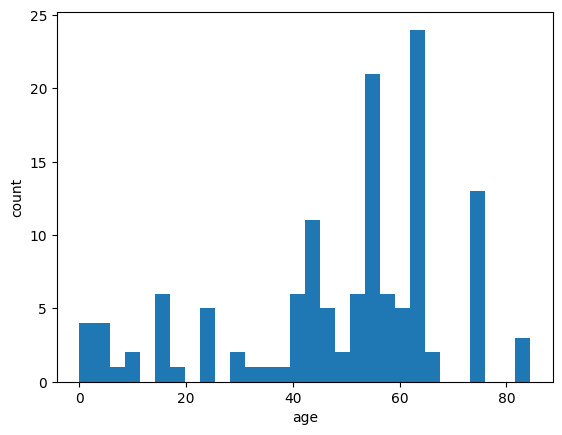

In [50]:
plt.hist(donor_information['age'], bins = 30)
plt.xlabel("age")
plt.ylabel("count")
plt.show()

In [51]:
donor_information['study'] = pd.Categorical(donor_information['study'])
donor_information['technology'] = pd.Categorical(donor_information['technology'])
donor_information['sex'] = pd.Categorical(donor_information['sex'])

/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 27.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 41.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


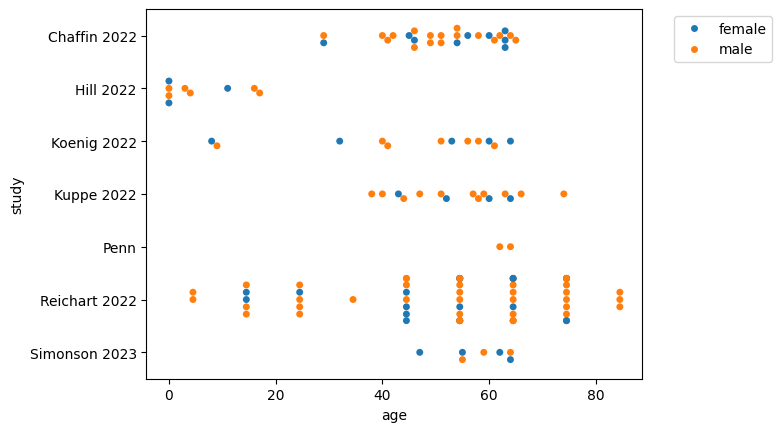

In [52]:
sns.swarmplot(data = donor_information, x='age', y='study', 
              hue = 'sex', alpha=1)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#### Perform some initial preprocessing steps

In [53]:
all_adata

AnnData object with n_obs × n_vars = 1165503 × 16512
    obs: 'age', 'donor_id', 'sex', 'region', 'cell_type', 'disease', 'consistent_cell_type', 'study', 'technology', 'cell_or_nuclei', 'sample_id', 'barcode'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'counts'

### Examine sex-specific expression
Based on the analysis of some sex-specific genes

In [54]:
metadata_at_donor_level = all_adata.obs.reset_index(drop = True)[["age", "sex", "donor_id"]].drop_duplicates()

# pseudobulk
pseudobulked_adata = sc.get.aggregate(all_adata, by=["donor_id"], func="sum")
pseudobulked_adata.X = pseudobulked_adata.layers['sum']

In [55]:
# These are genes that have strong sex-specific expression
female_sex_specific_genes = ['TSIX', 'XIST']
male_sex_specific_genes = ['DDX3Y', 'EIF1AY', 'KDM5D', 'LINC00278', 'RPS4Y1',
                             'TMSB4Y', 'TTTY10', 'TTTY14', 'USP9Y', 'UTY', 'ZFY', 'ZFY-AS1']
combined_sex_specific_genes = female_sex_specific_genes + male_sex_specific_genes

In [56]:
pseudobulked_adata.X = pseudobulked_adata.layers['sum']

In [57]:
sex_specific_pseudobulked_adata = pseudobulked_adata[:, pseudobulked_adata.var.index.isin(combined_sex_specific_genes)]
sex_specific_pseudobulked_adata.X = sex_specific_pseudobulked_adata.layers['sum']

/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


In [58]:
%%time
sc.pp.normalize_total(sex_specific_pseudobulked_adata)
sc.pp.log1p(sex_specific_pseudobulked_adata)
sc.pp.scale(sex_specific_pseudobulked_adata)
sc.pp.highly_variable_genes(sex_specific_pseudobulked_adata, n_top_genes=100)
sc.tl.pca(sex_specific_pseudobulked_adata)

CPU times: user 17.2 ms, sys: 6.03 ms, total: 23.3 ms
Wall time: 27.7 ms


/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [59]:
# add more metadata to the pseudobulked metadata
sex_specific_pseudobulked_adata.obs = sex_specific_pseudobulked_adata.obs.merge(metadata_at_donor_level, on = "donor_id", how = "inner")

#### Visualize PCA clusters in easier to edit format

In [60]:
pseudobulked_metadata = sex_specific_pseudobulked_adata.obs

In [61]:
pseudobulked_metadata['PC1'] = sex_specific_pseudobulked_adata.obsm['X_pca'][:, 0]
pseudobulked_metadata['PC2'] = sex_specific_pseudobulked_adata.obsm['X_pca'][:, 1]

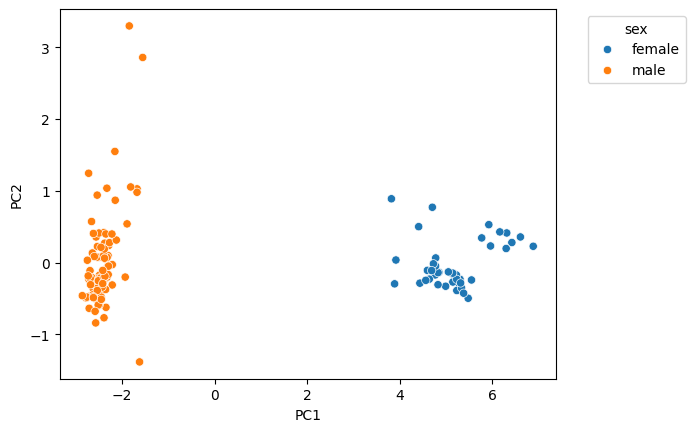

In [62]:
sns.scatterplot(data = pseudobulked_metadata,
                x = "PC1", y = "PC2", hue = "sex")
plt.legend(title='sex', bbox_to_anchor=(1.05, 1), loc='upper left')

In [63]:
pseudobulked_metadata[(pseudobulked_metadata['PC1'] > 0) & (pseudobulked_metadata['sex'] == "male")]

,donor_id,age,sex,PC1,PC2


In [64]:
pseudobulked_metadata[(pseudobulked_metadata['PC1'] < 0) & (pseudobulked_metadata['sex'] == "female")]

,donor_id,age,sex,PC1,PC2


There seem to be no donors that are misannotated by sex

#### Save the combined adata

In [65]:
all_adata.obs['age'] = all_adata.obs['age'].astype('float')
all_adata.var_names = all_adata.var_names.astype(str)

Add tech plus study as batch effect

In [66]:
all_adata.obs['tech_plus_study'] = all_adata.obs['technology'].astype(str) + "_" + all_adata.obs['study'].astype(str)

In [67]:
set(all_adata.obs.tech_plus_study)

{'3prime-v3_Chaffin 2022',
 '3prime-v3_Hill 2022',
 '3prime-v3_Kuppe 2022',
 '3prime-v3_Reichart 2022',
 '3prime-v3_Simonson 2023',
 '5prime-v1_Koenig 2022',
 'Dropseq_Penn'}

In [68]:
set(all_adata.obs.consistent_cell_type)

{'Adipocyte',
 'Cardiomyocyte',
 'Endocardial',
 'Endothelial',
 'Epicardial',
 'Fibroblast',
 'LEC',
 'Lymphoid',
 'Mast',
 'Myeloid',
 'Neuronal',
 'Pericyte',
 'Unclear',
 'vSMC'}

In [69]:
set(all_adata.obs.sex)

{'female', 'male'}

In [70]:
set(all_adata.obs.technology)

{'3prime-v3', '5prime-v1', 'Dropseq'}

In [71]:
set(all_adata.obs.disease)

{'AMI',
 'DCM',
 'HCM',
 'ICM',
 'arrhythmogenic right ventricular cardiomyopathy',
 'dilated cardiomyopathy',
 'non-compaction cardiomyopathy',
 'pediatric HF'}

In [72]:
all_adata.obs['age_status'] = "postnatal"

### Make the disease consistent

In [73]:
all_adata.obs.disease = all_adata.obs.disease.astype(str)
all_adata.obs.loc[all_adata.obs.disease == "arrhythmogenic right ventricular cardiomyopathy", 'disease'] = "ARVC"
all_adata.obs.loc[all_adata.obs.disease == "dilated cardiomyopathy", 'disease'] = "DCM"
all_adata.obs.loc[all_adata.obs.disease == "non-compaction cardiomyopathy", 'disease'] = "NCCM"

In [74]:
set(all_adata.obs.disease)

{'AMI', 'ARVC', 'DCM', 'HCM', 'ICM', 'NCCM', 'pediatric HF'}

In [75]:
# finally, reconfirm that these are the raw counts
confirm_raw_counts(all_adata)

True

In [76]:
all_adata.write("01_combined_LV_diseased.h5ad")
gc.collect()

4372